# **Importing Some Basic Libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

# **Initializing GPU Usage**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# **Importing Data**

In [ ]:
IMGSIZE = 90
transform1 = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(0.2),
                                transforms.ToTensor(),
                                transforms.Resize((IMGSIZE,IMGSIZE))
                               ])

In [ ]:
full_data = torchvision.datasets.ImageFolder(root = '../input/plantvillage-dataset/color', transform = transform1)

In [ ]:
classes = full_data.classes
print("Classes:",classes)
num_classes = len(full_data.classes)
print("Number of Classes:",num_classes)

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

# **Train-Test Data Split**

In [ ]:
# In 80% & 20% ratio
train_data, test_data = torch.utils.data.random_split(full_data, [43429, 10876], generator=torch.Generator().manual_seed(42))  


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 46, shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 46, shuffle = True)

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 11))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

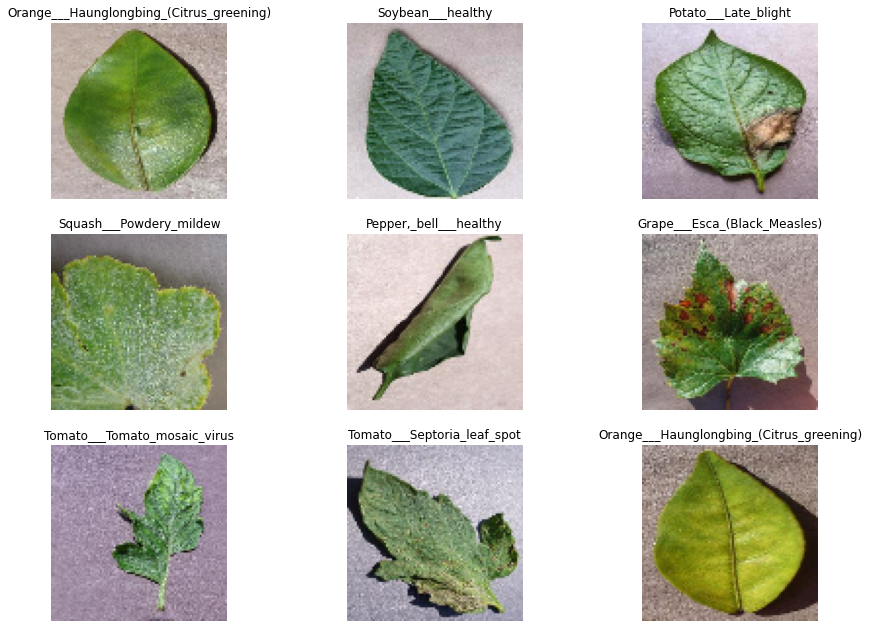

In [ ]:
N_IMAGES = 9

images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])

classes = full_data.classes

plot_images(images, labels, classes)

# **Modified CNN**

In [ ]:
num_classes=38

In [ ]:
class ModConvNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ModConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, num_classes)

        
    def forward(self, x):
        o = self.layer1(x)
        o = self.layer2(o)
        o = self.layer3(o)
        o = self.layer4(o)
        o = self.layer5(o)
        o = self.layer6(o)
        o = o.reshape(o.size(0), -1)
        o = self.fc1(o)
        o = F.dropout(o, training=self.training)
        o = self.fc2(o)
        o = F.dropout(o, training=self.training)
        o = self.fc3(o)
        return F.log_softmax(o,dim=1)

model = ModConvNet(num_classes).to(device)

In [ ]:
print(model)

ModConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): B

## **Criteria and Adam Optimizer**

In [ ]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(model.parameters(),lr=1e-5,weight_decay=1e-5)

In [ ]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [ ]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        model.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 1.16;   Train Accuracy : 53.47%;   Test Loss : 1.01;   Test Accuracy : 76.72%
Epoch 2 =>  Train Loss : 2.19;   Train Accuracy : 74.81%;   Test Loss : 0.86;   Test Accuracy : 84.86%
Epoch 3 =>  Train Loss : 1.49;   Train Accuracy : 82.25%;   Test Loss : 0.48;   Test Accuracy : 88.52%
Epoch 4 =>  Train Loss : 0.85;   Train Accuracy : 86.47%;   Test Loss : 0.17;   Test Accuracy : 90.96%
Epoch 5 =>  Train Loss : 1.21;   Train Accuracy : 89.61%;   Test Loss : 0.24;   Test Accuracy : 92.85%
Epoch 6 =>  Train Loss : 0.37;   Train Accuracy : 91.27%;   Test Loss : 0.34;   Test Accuracy : 93.59%
Epoch 7 =>  Train Loss : 0.46;   Train Accuracy : 92.73%;   Test Loss : 0.34;   Test Accuracy : 94.35%
Epoch 8 =>  Train Loss : 0.91;   Train Accuracy : 93.80%;   Test Loss : 0.06;   Test Accuracy : 95.37%
Epoch 9 =>  Train Loss : 0.70;   Train Accuracy : 94.84%;   Test Loss : 0.25;   Test Accuracy : 95.27%
Epoch 10 =>  Train Loss : 0.06;   Train Accuracy : 95.51%;   Test Loss : 

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'ModCNNModel.ckpt')

In [ ]:
model.load_state_dict(torch.load('./ModCNNModel.ckpt'))
model.eval()

ModConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): B

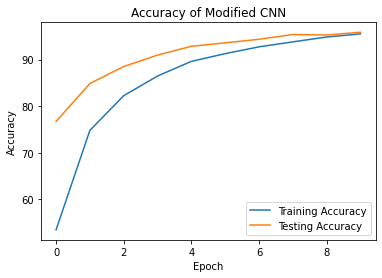

In [ ]:
plt.plot(range(10),TrainAcc)
plt.plot(range(10),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of Modified CNN")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

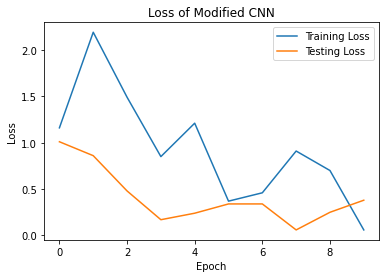

In [ ]:
TrainLoss_lst = []
for i in TrainLoss:
    TrainLoss_lst.append(i.item())
    
TestLoss_lst = []
for i in TestLoss:
    TestLoss_lst.append(i.item())
  
# TrainLoss_lst = [1.16, 2.19, 1.49, 0.85, 1.21, 0.37, 0.46, 0.91, 0.70, 0.06]
# TestLoss_lst = [1.01, 0.86, 0.48, 0.17, 0.24, 0.34, 0.34, 0.06, 0.25, 0.38]

plt.plot(range(10),TrainLoss_lst)
plt.plot(range(10),TestLoss_lst)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of Modified CNN")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

# **Transfer Learning:**

# **ResNet18**

In [ ]:
resnet18 = models.resnet18(pretrained=True)

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
q = resnet18.fc.in_features


resnet18.fc = nn.Sequential(
                 nn.Dropout(0.3),
                 nn.Linear(q, num_classes))


resnet18 = resnet18.cuda()

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(resnet18.parameters(),lr=1e-5,weight_decay=1e-5)

In [ ]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [ ]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        resnet18.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet18(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        resnet18.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = resnet18(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 0.75;   Train Accuracy : 65.19%;   Test Loss : 0.67;   Test Accuracy : 89.44%
Epoch 2 =>  Train Loss : 1.51;   Train Accuracy : 91.05%;   Test Loss : 0.07;   Test Accuracy : 94.43%
Epoch 3 =>  Train Loss : 0.08;   Train Accuracy : 95.12%;   Test Loss : 0.08;   Test Accuracy : 96.88%
Epoch 4 =>  Train Loss : 0.85;   Train Accuracy : 96.74%;   Test Loss : 0.15;   Test Accuracy : 97.65%
Epoch 5 =>  Train Loss : 0.13;   Train Accuracy : 97.72%;   Test Loss : 0.04;   Test Accuracy : 98.11%
Epoch 6 =>  Train Loss : 0.44;   Train Accuracy : 98.33%;   Test Loss : 0.06;   Test Accuracy : 98.38%
Epoch 7 =>  Train Loss : 0.71;   Train Accuracy : 98.84%;   Test Loss : 0.01;   Test Accuracy : 98.57%
Epoch 8 =>  Train Loss : 0.15;   Train Accuracy : 99.14%;   Test Loss : 0.31;   Test Accuracy : 98.72%
Epoch 9 =>  Train Loss : 0.56;   Train Accuracy : 99.37%;   Test Loss : 0.03;   Test Accuracy : 98.82%
Epoch 10 =>  Train Loss : 0.03;   Train Accuracy : 99.57%;   Test Loss : 

In [ ]:
# Save the model checkpoint
torch.save(resnet18.state_dict(), 'ResNet18Model.ckpt')

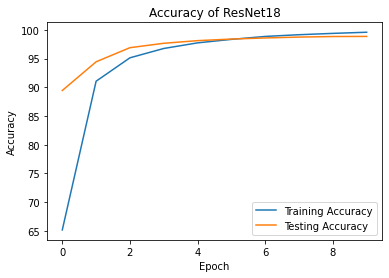

In [ ]:
plt.plot(range(10),TrainAcc)
plt.plot(range(10),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of ResNet18")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

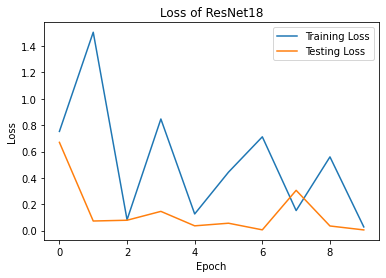

In [ ]:
TrainLoss_lst = []
for i in TrainLoss:
    TrainLoss_lst.append(i.item())
    
TestLoss_lst = []
for i in TestLoss:
    TestLoss_lst.append(i.item())
    
plt.plot(range(10),TrainLoss_lst)
plt.plot(range(10),TestLoss_lst)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of ResNet18")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

# **VGG16**

In [ ]:
vgg16 = models.vgg16(pretrained=True)

In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
q = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(q, num_classes)


vgg16 = vgg16.cuda()

In [ ]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(vgg16.parameters(),lr=1e-5,weight_decay=1e-5)

In [ ]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [ ]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        vgg16.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = vgg16(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        vgg16.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = vgg16(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 0.12;   Train Accuracy : 73.69%;   Test Loss : 0.09;   Test Accuracy : 91.60%
Epoch 2 =>  Train Loss : 0.03;   Train Accuracy : 92.37%;   Test Loss : 0.21;   Test Accuracy : 94.79%
Epoch 3 =>  Train Loss : 0.31;   Train Accuracy : 95.53%;   Test Loss : 0.02;   Test Accuracy : 96.71%
Epoch 4 =>  Train Loss : 0.00;   Train Accuracy : 96.98%;   Test Loss : 0.00;   Test Accuracy : 96.62%
Epoch 5 =>  Train Loss : 0.04;   Train Accuracy : 97.89%;   Test Loss : 0.24;   Test Accuracy : 97.31%
Epoch 6 =>  Train Loss : 0.00;   Train Accuracy : 98.35%;   Test Loss : 0.04;   Test Accuracy : 98.12%
Epoch 7 =>  Train Loss : 0.00;   Train Accuracy : 98.67%;   Test Loss : 0.01;   Test Accuracy : 97.12%
Epoch 8 =>  Train Loss : 0.00;   Train Accuracy : 98.89%;   Test Loss : 0.01;   Test Accuracy : 98.03%
Epoch 9 =>  Train Loss : 0.00;   Train Accuracy : 99.16%;   Test Loss : 0.04;   Test Accuracy : 98.34%
Epoch 10 =>  Train Loss : 0.00;   Train Accuracy : 99.29%;   Test Loss : 

In [ ]:
# Save the model checkpoint
torch.save(vgg16.state_dict(), 'VGG16Model.ckpt')

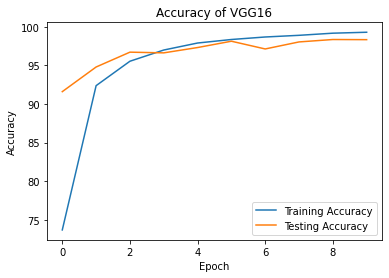

In [ ]:
plt.plot(range(10),TrainAcc)
plt.plot(range(10),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of VGG16")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

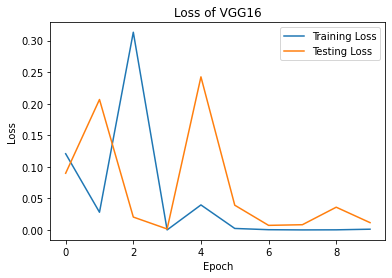

In [ ]:
TrainLoss_lst = []
for i in TrainLoss:
    TrainLoss_lst.append(i.item())
    
TestLoss_lst = []
for i in TestLoss:
    TestLoss_lst.append(i.item())
    
plt.plot(range(10),TrainLoss_lst)
plt.plot(range(10),TestLoss_lst)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of VGG16")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

# **GoogleNet**

In [ ]:
googlenet = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
q = googlenet.fc.in_features


googlenet.fc = nn.Sequential(
                 nn.Dropout(0.3),
                 nn.Linear(q, num_classes))


googlenet = googlenet.cuda()

In [ ]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(googlenet.parameters(),lr=1e-5,weight_decay=1e-5)

In [ ]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [ ]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        googlenet.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = googlenet(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        googlenet.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = googlenet(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 2.07;   Train Accuracy : 37.45%;   Test Loss : 0.93;   Test Accuracy : 61.06%
Epoch 2 =>  Train Loss : 2.98;   Train Accuracy : 68.42%;   Test Loss : 0.53;   Test Accuracy : 80.22%
Epoch 3 =>  Train Loss : 0.55;   Train Accuracy : 81.51%;   Test Loss : 0.70;   Test Accuracy : 88.08%
Epoch 4 =>  Train Loss : 2.18;   Train Accuracy : 88.01%;   Test Loss : 0.15;   Test Accuracy : 91.91%
Epoch 5 =>  Train Loss : 0.86;   Train Accuracy : 91.21%;   Test Loss : 0.25;   Test Accuracy : 93.82%
Epoch 6 =>  Train Loss : 2.29;   Train Accuracy : 93.42%;   Test Loss : 0.05;   Test Accuracy : 95.21%
Epoch 7 =>  Train Loss : 0.64;   Train Accuracy : 94.74%;   Test Loss : 0.48;   Test Accuracy : 95.81%
Epoch 8 =>  Train Loss : 0.40;   Train Accuracy : 95.82%;   Test Loss : 0.15;   Test Accuracy : 96.47%
Epoch 9 =>  Train Loss : 3.34;   Train Accuracy : 96.69%;   Test Loss : 0.02;   Test Accuracy : 97.05%
Epoch 10 =>  Train Loss : 0.07;   Train Accuracy : 97.17%;   Test Loss : 

In [ ]:
# Save the model checkpoint
torch.save(googlenet.state_dict(), 'GoogleNetModel.ckpt')

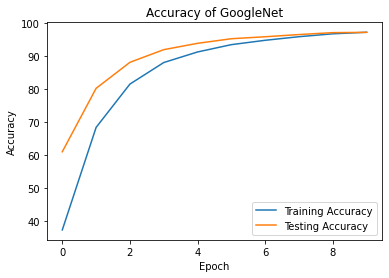

In [ ]:
plt.plot(range(10),TrainAcc)
plt.plot(range(10),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of GoogleNet")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

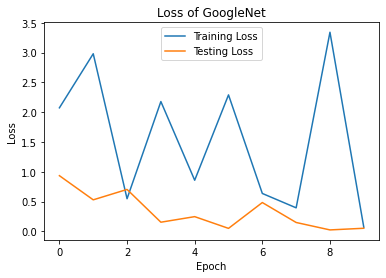

In [ ]:
TrainLoss_lst = []
for i in TrainLoss:
    TrainLoss_lst.append(i.item())
    
TestLoss_lst = []
for i in TestLoss:
    TestLoss_lst.append(i.item())
    
plt.plot(range(10),TrainLoss_lst)
plt.plot(range(10),TestLoss_lst)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of GoogleNet")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

# **AlexNet**

In [ ]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
q = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(q, num_classes)


alexnet = alexnet.cuda()

In [ ]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(alexnet.parameters(),lr=1e-5,weight_decay=1e-5)

In [ ]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [ ]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        alexnet.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = alexnet(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        alexnet.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = alexnet(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 0.97;   Train Accuracy : 67.22%;   Test Loss : 0.44;   Test Accuracy : 85.15%
Epoch 2 =>  Train Loss : 0.90;   Train Accuracy : 86.53%;   Test Loss : 0.30;   Test Accuracy : 90.00%
Epoch 3 =>  Train Loss : 0.28;   Train Accuracy : 90.62%;   Test Loss : 0.10;   Test Accuracy : 92.34%
Epoch 4 =>  Train Loss : 0.08;   Train Accuracy : 93.04%;   Test Loss : 0.22;   Test Accuracy : 93.37%
Epoch 5 =>  Train Loss : 0.03;   Train Accuracy : 94.37%;   Test Loss : 0.60;   Test Accuracy : 94.69%
Epoch 6 =>  Train Loss : 0.00;   Train Accuracy : 95.36%;   Test Loss : 0.02;   Test Accuracy : 94.98%
Epoch 7 =>  Train Loss : 0.14;   Train Accuracy : 95.97%;   Test Loss : 0.23;   Test Accuracy : 95.26%
Epoch 8 =>  Train Loss : 0.00;   Train Accuracy : 96.65%;   Test Loss : 0.13;   Test Accuracy : 95.53%
Epoch 9 =>  Train Loss : 0.00;   Train Accuracy : 96.97%;   Test Loss : 0.36;   Test Accuracy : 96.06%
Epoch 10 =>  Train Loss : 0.03;   Train Accuracy : 97.37%;   Test Loss : 

In [ ]:
# Save the model checkpoint
torch.save(alexnet.state_dict(), 'AlexNetModel.ckpt')

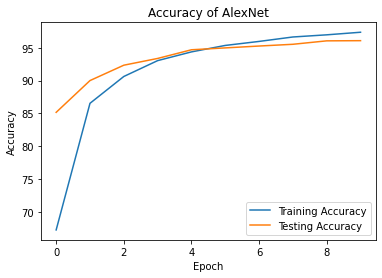

In [ ]:
plt.plot(range(10),TrainAcc)
plt.plot(range(10),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of AlexNet")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

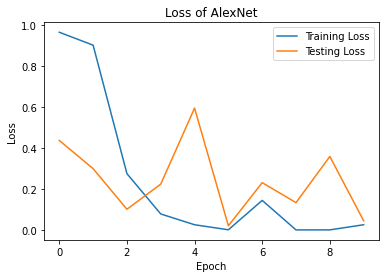

In [ ]:
TrainLoss_lst = []
for i in TrainLoss:
    TrainLoss_lst.append(i.item())
    
TestLoss_lst = []
for i in TestLoss:
    TestLoss_lst.append(i.item())
    
plt.plot(range(10),TrainLoss_lst)
plt.plot(range(10),TestLoss_lst)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of AlexNet")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

# **ResNet50**

In [ ]:
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
q = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
                 nn.Dropout(0.3),
                 nn.Linear(q, num_classes))

resnet50 = resnet50.cuda()

In [ ]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(resnet50.parameters(),lr=1e-5,weight_decay=1e-5)

In [ ]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [ ]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        resnet50.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet50(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        resnet50.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = resnet50(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 2.14;   Train Accuracy : 73.26%;   Test Loss : 0.20;   Test Accuracy : 94.97%
Epoch 2 =>  Train Loss : 0.35;   Train Accuracy : 95.41%;   Test Loss : 0.03;   Test Accuracy : 97.79%
Epoch 3 =>  Train Loss : 0.21;   Train Accuracy : 97.75%;   Test Loss : 0.02;   Test Accuracy : 98.45%
Epoch 4 =>  Train Loss : 1.71;   Train Accuracy : 98.80%;   Test Loss : 0.01;   Test Accuracy : 98.90%
Epoch 5 =>  Train Loss : 0.42;   Train Accuracy : 99.15%;   Test Loss : 0.32;   Test Accuracy : 99.03%
Epoch 6 =>  Train Loss : 0.22;   Train Accuracy : 99.44%;   Test Loss : 0.00;   Test Accuracy : 98.95%
Epoch 7 =>  Train Loss : 1.50;   Train Accuracy : 99.58%;   Test Loss : 0.00;   Test Accuracy : 99.14%
Epoch 8 =>  Train Loss : 1.75;   Train Accuracy : 99.65%;   Test Loss : 0.00;   Test Accuracy : 99.00%
Epoch 9 =>  Train Loss : 0.06;   Train Accuracy : 99.77%;   Test Loss : 0.01;   Test Accuracy : 99.30%
Epoch 10 =>  Train Loss : 0.64;   Train Accuracy : 99.75%;   Test Loss : 

In [ ]:
# Save the model checkpoint
torch.save(resnet50.state_dict(), 'resnet50Model.ckpt')

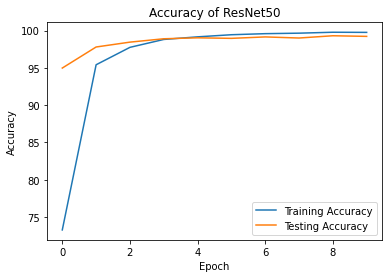

In [ ]:
plt.plot(range(10),TrainAcc)
plt.plot(range(10),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of ResNet50")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

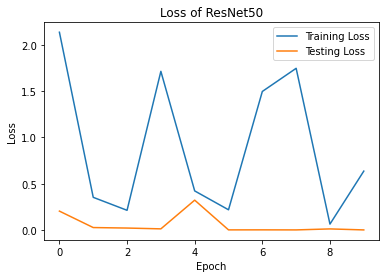

In [ ]:
TrainLoss_lst = []
for i in TrainLoss:
    TrainLoss_lst.append(i.item())
    
TestLoss_lst = []
for i in TestLoss:
    TestLoss_lst.append(i.item())
    
plt.plot(range(10),TrainLoss_lst)
plt.plot(range(10),TestLoss_lst)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of ResNet50")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

# **ResNet101**

In [ ]:
resnet101 = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
print(resnet101)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
q = resnet101.fc.in_features

resnet101.fc = nn.Sequential(
                 nn.Dropout(0.3),
                 nn.Linear(q, num_classes))

resnet101 = resnet101.cuda()

In [ ]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(resnet101.parameters(),lr=1e-5,weight_decay=1e-5)

In [ ]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [ ]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        resnet101.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet101(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        resnet101.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = resnet101(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 1.24;   Train Accuracy : 76.12%;   Test Loss : 0.05;   Test Accuracy : 96.25%
Epoch 2 =>  Train Loss : 0.59;   Train Accuracy : 96.29%;   Test Loss : 0.01;   Test Accuracy : 98.25%
Epoch 3 =>  Train Loss : 0.22;   Train Accuracy : 98.20%;   Test Loss : 0.00;   Test Accuracy : 98.69%
Epoch 4 =>  Train Loss : 0.40;   Train Accuracy : 98.94%;   Test Loss : 0.00;   Test Accuracy : 98.69%
Epoch 5 =>  Train Loss : 0.09;   Train Accuracy : 99.32%;   Test Loss : 0.25;   Test Accuracy : 98.97%
Epoch 6 =>  Train Loss : 0.99;   Train Accuracy : 99.55%;   Test Loss : 0.00;   Test Accuracy : 99.01%
Epoch 7 =>  Train Loss : 0.96;   Train Accuracy : 99.60%;   Test Loss : 0.00;   Test Accuracy : 99.20%
Epoch 8 =>  Train Loss : 0.37;   Train Accuracy : 99.65%;   Test Loss : 0.00;   Test Accuracy : 99.08%
Epoch 9 =>  Train Loss : 0.21;   Train Accuracy : 99.70%;   Test Loss : 0.00;   Test Accuracy : 99.13%
Epoch 10 =>  Train Loss : 0.07;   Train Accuracy : 99.73%;   Test Loss : 

In [ ]:
# Save the model checkpoint
torch.save(resnet101.state_dict(), 'resnet101Model.ckpt')

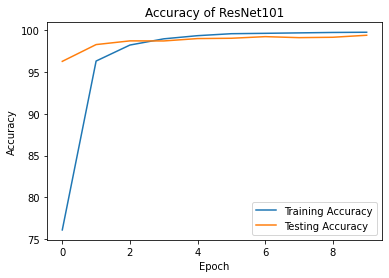

In [ ]:
plt.plot(range(10),TrainAcc)
plt.plot(range(10),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of ResNet101")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

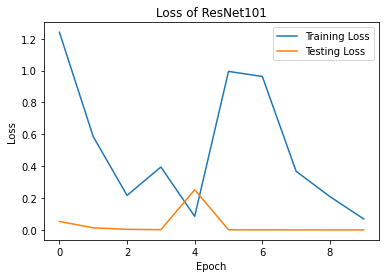

In [ ]:
TrainLoss_lst = []
for i in TrainLoss:
    TrainLoss_lst.append(i.item())
    
TestLoss_lst = []
for i in TestLoss:
    TestLoss_lst.append(i.item())
    
plt.plot(range(10),TrainLoss_lst)
plt.plot(range(10),TestLoss_lst)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of ResNet101")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

# **ResNet152**

In [ ]:
resnet152 = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
print(resnet152)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
q = resnet152.fc.in_features

resnet152.fc = nn.Sequential(
                 nn.Dropout(0.3),
                 nn.Linear(q, num_classes))

resnet152 = resnet152.cuda()

In [ ]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(resnet152.parameters(),lr=1e-5,weight_decay=1e-5)

In [ ]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 10

In [ ]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        resnet152.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet152(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        resnet152.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = resnet152(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 2.05;   Train Accuracy : 77.30%;   Test Loss : 0.06;   Test Accuracy : 96.35%
Epoch 2 =>  Train Loss : 0.77;   Train Accuracy : 96.81%;   Test Loss : 0.01;   Test Accuracy : 98.27%
Epoch 3 =>  Train Loss : 1.96;   Train Accuracy : 98.58%;   Test Loss : 0.03;   Test Accuracy : 98.76%
Epoch 4 =>  Train Loss : 0.92;   Train Accuracy : 99.10%;   Test Loss : 0.15;   Test Accuracy : 98.90%
Epoch 5 =>  Train Loss : 0.05;   Train Accuracy : 99.42%;   Test Loss : 0.00;   Test Accuracy : 99.11%


KeyboardInterrupt: 

In [ ]:
# Save the model checkpoint
torch.save(resnet152.state_dict(), 'resnet152Model.ckpt')

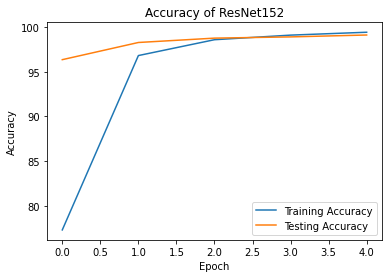

In [ ]:
plt.plot(range(5),TrainAcc)
plt.plot(range(5),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of ResNet152")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

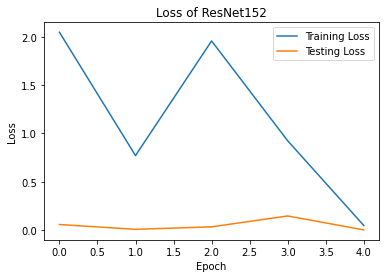

In [ ]:
TrainLoss_lst = []
for i in TrainLoss:
    TrainLoss_lst.append(i.item())
    
TestLoss_lst = []
for i in TestLoss:
    TestLoss_lst.append(i.item())
    
plt.plot(range(5),TrainLoss_lst)
plt.plot(range(5),TestLoss_lst)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of ResNet152")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

# **DenseNet161**

In [ ]:
densenet161 = models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [ ]:
print(densenet161)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
q = densenet161.classifier.in_features

densenet161.classifier = nn.Sequential(
                 nn.Dropout(0.3),
                 nn.Linear(q, num_classes))

densenet161 = densenet161.cuda()

In [ ]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(densenet161.parameters(),lr=1e-5,weight_decay=1e-5)

In [ ]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 5

In [ ]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        densenet161.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = densenet161(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        densenet161.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = densenet161(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 0.81;   Train Accuracy : 66.36%;   Test Loss : 0.25;   Test Accuracy : 91.94%
Epoch 2 =>  Train Loss : 0.72;   Train Accuracy : 93.70%;   Test Loss : 0.37;   Test Accuracy : 97.34%
Epoch 3 =>  Train Loss : 0.61;   Train Accuracy : 97.24%;   Test Loss : 0.03;   Test Accuracy : 98.34%
Epoch 4 =>  Train Loss : 0.16;   Train Accuracy : 98.37%;   Test Loss : 0.02;   Test Accuracy : 98.95%
Epoch 5 =>  Train Loss : 1.18;   Train Accuracy : 99.09%;   Test Loss : 0.09;   Test Accuracy : 99.05%


In [ ]:
# Save the model checkpoint
torch.save(densenet161.state_dict(), 'densenet161Model.ckpt')

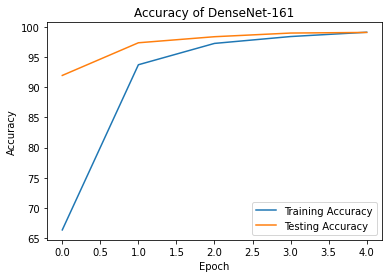

In [ ]:
plt.plot(range(5),TrainAcc)
plt.plot(range(5),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of DenseNet-161")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

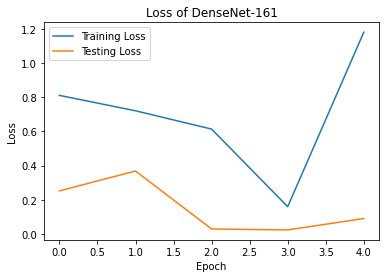

In [ ]:
TrainLoss_lst = []
for i in TrainLoss:
    TrainLoss_lst.append(i.item())
    
TestLoss_lst = []
for i in TestLoss:
    TestLoss_lst.append(i.item())
    
plt.plot(range(5),TrainLoss_lst)
plt.plot(range(5),TestLoss_lst)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of DenseNet-161")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

# **DenseNet201**

In [ ]:
densenet201 = models.densenet201(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [ ]:
print(densenet201)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
q = densenet201.classifier.in_features

densenet201.classifier = nn.Sequential(
                 nn.Dropout(0.3),
                 nn.Linear(q, num_classes))

densenet201 = densenet201.cuda()

In [ ]:
criter = nn.CrossEntropyLoss()
optimz = torch.optim.Adam(densenet201.parameters(),lr=1e-5,weight_decay=1e-5)

In [ ]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 5

In [ ]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    trainAcc = 0
    testAcc = 0
    for i, (images, labels) in enumerate(train_loader):
        densenet201.train()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = densenet201(images)
        trainloss = criter(outputs, labels)
        
        # Backward and optimize
        optimz.zero_grad()
        trainloss.backward()
        optimz.step()
        
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    trainAcc = trainAcc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(test_loader):
        densenet201.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = densenet201(images)
        testloss = criter(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    testAcc = testAcc/len(test_loader.dataset) * 100
    
    print("Epoch {} =>  Train Loss : {trainloss:.2f};   Train Accuracy : {trainAcc:.2f}%;   Test Loss : {testloss:.2f};   Test Accuracy : {testAcc:.2f}%".format(epoch+1, trainloss=trainloss.item(), trainAcc=trainAcc, testloss=testloss.item(), testAcc=testAcc))
  
    TrainLoss.append(trainloss)
    TrainAcc.append(trainAcc)

    TestLoss.append(testloss)
    TestAcc.append(testAcc)

Epoch 1 =>  Train Loss : 1.39;   Train Accuracy : 61.33%;   Test Loss : 0.88;   Test Accuracy : 87.84%
Epoch 2 =>  Train Loss : 1.01;   Train Accuracy : 91.34%;   Test Loss : 0.38;   Test Accuracy : 96.02%
Epoch 3 =>  Train Loss : 0.67;   Train Accuracy : 96.01%;   Test Loss : 0.14;   Test Accuracy : 97.57%
Epoch 4 =>  Train Loss : 1.30;   Train Accuracy : 97.68%;   Test Loss : 0.18;   Test Accuracy : 98.44%
Epoch 5 =>  Train Loss : 0.26;   Train Accuracy : 98.51%;   Test Loss : 0.02;   Test Accuracy : 98.78%


In [ ]:
# Save the model checkpoint
torch.save(densenet201.state_dict(), 'densenet201Model.ckpt')

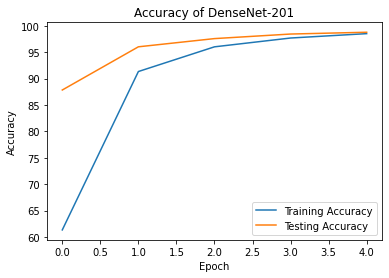

In [ ]:
plt.plot(range(5),TrainAcc)
plt.plot(range(5),TestAcc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of DenseNet-201")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

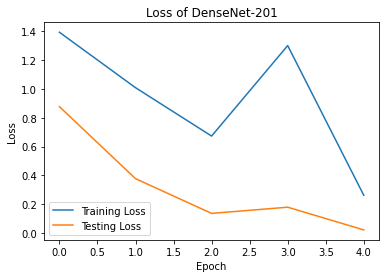

In [ ]:
TrainLoss_lst = []
for i in TrainLoss:
    TrainLoss_lst.append(i.item())
    
TestLoss_lst = []
for i in TestLoss:
    TestLoss_lst.append(i.item())
    
plt.plot(range(5),TrainLoss_lst)
plt.plot(range(5),TestLoss_lst)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of DenseNet-201")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

In [ ]:
p = model1.predict(val_generator)
p = np.argmax(p, axis=1)
y_true = val_generator.classes
c = confusion_matrix(p, y_true)

plt.figure(figsize=(48,38))
plt.title('Confusion matrix')
sns.heatmap(c, annot=True)
plt.plot()
plt.savefig("model1_Confusion_matrix.png")

# **Comparing Accuracy and Loss of Above Models  :**

| <h3><b>Model</b></h3> | <h3><b>Train Loss</b></h3> | <h3><b>Train Accuracy</b></h3> | <h3><b>Test Loss</b></h3> | <h3><b>Test Accuracy</b></h3> |
| --- | --- | --- |--- | --- |
| <h5><b>Modified CNN</b></h5> | <h5>0.06</h5> | <h5>95.51%</h5> | <h5>0.38</h5> | <h5>95.86%</h5> |
| <h5><b>ResNet18</b></h5> | <h5>0.03</h5> | <h5>99.57%</h5> | <h5>0.00</h5> | <h5>98.84%</h5> |
| <h5><b>VGG16</b></h5> | <h5>0.00</h5> | <h5>99.29%</h5> | <h5>0.01</h5> | <h5>98.33%</h5> |
| <h5><b>GoogleNet</b></h5> | <h5>0.07</h5> | <h5>97.17%</h5> | <h5>0.05</h5> | <h5>97.13%</h5> |
| <h5><b>AlexNet</b></h5> | <h5>0.03</h5> | <h5>97.37%</h5> | <h5>0.04</h5> | <h5>96.08%</h5> |
| <h5><b>ResNet50</b></h5> | <h5>0.64</h5> | <h5>99.75%</h5> | <h5>0.00</h5> | <h5>99.22%</h5> |
| <h5><b>ResNet101</b></h5> | <h5>0.07</h5> | <h5>99.73%</h5> | <h5>0.00</h5> | <h5>99.37%</h5> |
| <h5><b>ResNet152</b></h5> | <h5>0.05</h5> | <h5>99.42%</h5> | <h5>0.00</h5> | <h5>99.11%</h5> |
| <h5><b>DenseNet161</b></h5> | <h5>1.18</h5> | <h5>99.09%</h5> | <h5>0.09</h5> | <h5>99.05%</h5> |
| <h5><b>DenseNet201</b></h5> | <h5>0.26</h5> | <h5>98.51%</h5> | <h5>0.02</h5> | <h5>98.78%</h5> |
